In this project we will analyze a bank loan dataset that evaluates clients. We use the ydata-profiling library to create a report which simplifies the baseline analysis.

In [212]:
#!pip install ydata-profiling

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

#1. Baseline Analysis

In [5]:
df = pd.read_csv('bankloan.csv')
df

,Row ID,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,...,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Unnamed: 50,36months,60months
0,1.0,60516983,64537751,20000,20000,36 months,12.29,667.06,C,C1,...,INDIVIDUAL,NaN,NaN,0,0,52303,41000,NaN,1.0,0.0
1,2.0,60187139,64163931,11000,11000,36 months,12.69,369.00,C,C2,...,INDIVIDUAL,NaN,NaN,0,332,175731,13100,NaN,1.0,0.0
2,3.0,60356453,64333218,7000,7000,36 months,9.99,225.84,B,B3,...,INDIVIDUAL,NaN,NaN,0,0,202012,16300,NaN,1.0,0.0
3,4.0,59955769,63900496,10000,10000,36 months,10.99,327.34,B,B4,...,INDIVIDUAL,NaN,NaN,0,0,108235,34750,NaN,1.0,0.0
4,5.0,58703693,62544456,9550,9550,36 months,19.99,354.87,E,E4,...,INDIVIDUAL,NaN,NaN,0,0,45492,14100,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212994,NaN,54067695,57608436,20000,20000,36 months,13.33,677.07,C,C3,...,INDIVIDUAL,NaN,NaN,0,574,21474,5400,NaN,NaN,NaN
212995,NaN,54414443,57995197,6000,6000,36 months,11.53,197.95,B,B5,...,INDIVIDUAL,NaN,NaN,0,0,2176,4200,NaN,NaN,NaN
212996,NaN,54474829,58055589,18000,18000,60 months,19.19,468.82,E,E3,...,INDIVIDUAL,NaN,NaN,0,4404,8414,15300,NaN,NaN,NaN
212997,NaN,54354054,57934790,7050,7050,36 months,15.61,246.51,D,D1,...,INDIVIDUAL,NaN,NaN,0,0,159660,26800,NaN,NaN,NaN


In [213]:
#profile = ProfileReport(df, title="Profiling Report", explorative=True)
#profile.to_file("my_report.html")

After studying the report, regarding loan_amnt:
max: 35000,
min: 1000,
mean:15257.966.

#2. Feature engineering

In [6]:
df.columns

Index(['Row ID', 'id', 'member_id', 'loan_amnt', 'funded_amnt', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'title', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'total_pymnt', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'application_type', 'annual_inc_joint',
       'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'Unnamed: 50', '36months', '60months'],
      dtype='object')

In order to find the "useless" features we will use the report. Some (like id) are clearly pointless. Some have 95% of the times the same value. For these ones we will see whether they have a useful meaning and if they represent a useful outlier. But for most cases we will drop them. Other varaibles will be dropped because they have more than 90% missing values. After evaluation the dropped columns are the following.

In [83]:
useless_columns = ['id','Row ID','member_id','title','emp_title','loan_status','dti', 'earliest_cr_line','dti_joint','36months','60months','annual_inc_joint', 'recoveries','collection_recovery_fee', 'Unnamed: 50','last_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med','application_type','acc_now_delinq']

In [197]:
df_new=df.drop(columns=useless_columns)
df_new =  df_new.dropna()
df_new

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,next_pymnt_d,mths_since_last_major_derog,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
2783,8000,8000,36 months,8.49,252.51,B,B1,3 years,MORTGAGE,48000.00,...,0.00,0.00,0.00,0.0,0.00,16-Feb,62.0,0,123372,9000
2784,7000,7000,36 months,16.59,248.15,D,D2,2 years,MORTGAGE,30100.00,...,0.00,0.00,0.00,0.0,0.00,16-Feb,70.0,0,112712,21100
2791,8750,8750,36 months,18.99,320.70,E,E1,1 year,RENT,29524.32,...,237.61,182.22,55.39,0.0,260.69,16-Feb,24.0,0,94802,2500
2792,12000,12000,36 months,9.80,386.09,B,B3,5 years,RENT,43000.00,...,0.00,0.00,0.00,0.0,0.00,16-Feb,42.0,0,17981,28900
2797,21000,21000,36 months,9.17,669.46,B,B2,< 1 year,RENT,80000.00,...,0.00,0.00,0.00,0.0,610.61,16-Feb,29.0,0,33216,43800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212984,4525,4525,36 months,17.86,163.28,D,D5,9 years,MORTGAGE,35000.00,...,970.70,597.44,373.26,0.0,163.28,16-Feb,61.0,0,18373,8000
212985,5000,5000,36 months,6.89,154.14,A,A3,10+ years,RENT,47000.00,...,921.01,763.48,157.53,0.0,154.14,16-Feb,21.0,0,229177,25500
212988,31475,31475,60 months,15.61,758.91,D,D1,10+ years,RENT,91986.76,...,4526.16,2166.22,2359.94,0.0,758.91,16-Feb,40.0,0,294395,25700
212994,20000,20000,36 months,13.33,677.07,C,C3,5 years,RENT,120000.00,...,4120.02,2852.46,1267.56,0.0,700.00,16-Feb,45.0,574,21474,5400


In [85]:
df_new.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'purpose', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'last_pymnt_amnt', 'next_pymnt_d',
       'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim'],
      dtype='object')

Now we will do some preprocessing to convert some features into something useful. For some of the dates we will keep the months or the years. For categorical data we will transform them into numbers. We could do a more careful transformation for each one, so as to take into account their importance of each category as a feature. For now, we will proceed like this.

In [198]:
df_new['term'] = df_new['term'].str.replace(' months', '', regex=False).astype(int)
df_new['emp_length'] = df_new['emp_length'].str.replace(r'[^\d]','',regex=True).astype(int)

df_new['next_pymnt_d'] = pd.to_datetime(df_new['next_pymnt_d'] + '-2025', format='%d-%b-%Y')
df_new['next_pymnt_d_month'] = df_new['next_pymnt_d'].dt.month
df_new=df_new.drop(columns=['next_pymnt_d'])

df_new['issue_d'] = pd.to_datetime(df_new['issue_d'] + '-2025', format='%d-%b-%Y')
df_new['issue_d_month'] = df_new['issue_d'].dt.month
df_new=df_new.drop(columns=['issue_d'])

df_new['grade']= df_new['grade'].replace('A', 1)
df_new['grade']= df_new['grade'].replace('B', 2)
df_new['grade']= df_new['grade'].replace('C', 3)
df_new['grade']= df_new['grade'].replace('D', 4)
df_new['grade']= df_new['grade'].replace('E', 5)
df_new['grade']= df_new['grade'].replace('F', 6)
df_new['grade']= df_new['grade'].replace('G', 7)


df_new['home_ownership']= df_new['home_ownership'].replace('MORTGAGE', 1)
df_new['home_ownership']= df_new['home_ownership'].replace('RENT', 2)
df_new['home_ownership']= df_new['home_ownership'].replace('OWN', 3)
df_new['home_ownership']= df_new['home_ownership'].replace('ANY', 4)

df_new['verification_status']= df_new['verification_status'].replace('Not Verified', 1)
df_new['verification_status']= df_new['verification_status'].replace('Verified', 2)
df_new['verification_status']= df_new['verification_status'].replace('Source Verified', 3)

df_new['purpose']= df_new['purpose'].replace('credit_card', 1)
df_new['purpose']= df_new['purpose'].replace('debt_consolidation', 2)
df_new['purpose']= df_new['purpose'].replace('other', 3)
df_new['purpose']= df_new['purpose'].replace('home_improvement', 4)
df_new['purpose']= df_new['purpose'].replace('car', 5)
df_new['purpose']= df_new['purpose'].replace('major_purchase', 6)
df_new['purpose']= df_new['purpose'].replace('medical', 7)
df_new['purpose']= df_new['purpose'].replace('house', 8)
df_new['purpose']= df_new['purpose'].replace('vacation', 9)
df_new['purpose']= df_new['purpose'].replace('small_business', 10)
df_new['purpose']= df_new['purpose'].replace('moving', 11)
df_new['purpose']= df_new['purpose'].replace('renewable_energy',12)

df_new['initial_list_status']= df_new['initial_list_status'].replace('w', 1)
df_new['initial_list_status']= df_new['initial_list_status'].replace('f', 2)



/tmp/ipython-input-1047688201.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_new['grade']= df_new['grade'].replace('G', 7)
/tmp/ipython-input-1047688201.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_new['home_ownership']= df_new['home_ownership'].replace('ANY', 4)
/tmp/ipython-input-1047688201.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavio

In [200]:
df_new = df_new.reset_index()

In [201]:
df_new['target']=0
for i in range(len(df_new)):
  sub_gr=df_new.loc[i,'sub_grade']
  if sub_gr in ['A','B1','B2']:
    df_new.loc[i,'target']=1
df_new = df_new.drop(columns=['sub_grade'])
df_new['target']


,target
0,1
1,0
2,0
3,0
4,1
...,...
54292,0
54293,0
54294,0
54295,0


#3. Client Classification

In this part we will try to create a classifier for the target. We will normalize with standard scaling to avoid the negative effects of outliers that can appear in Min Max scaling. In addition, as we see there is clear class imbalance in the data.

In [202]:
scaler = StandardScaler()

In [203]:
df_new['target'].value_counts()

,count
target,
0,47649
1,6648


In [150]:
df_new.columns

Index(['index', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'last_pymnt_amnt', 'mths_since_last_major_derog', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'next_pymnt_d_month',
       'issue_d_month', 'target'],
      dtype='object')

We will remove some extra features (appart from the obsious grade and target) that may leak information, such as int_rate, which may be connected to grade.

In [204]:
x=df_new.drop(columns=['target','grade','index','int_rate'])
y=df_new[['target']]

In [205]:
x

,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,delinq_2yrs,...,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,mths_since_last_major_derog,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,next_pymnt_d_month,issue_d_month
0,8000,8000,36,252.51,3,1,48000.00,1,1,0,...,0.00,0.00,0.0,0.00,62.0,0,123372,9000,2,12
1,7000,7000,36,248.15,2,1,30100.00,2,2,3,...,0.00,0.00,0.0,0.00,70.0,0,112712,21100,2,12
2,8750,8750,36,320.70,1,2,29524.32,2,2,0,...,182.22,55.39,0.0,260.69,24.0,0,94802,2500,2,12
3,12000,12000,36,386.09,5,2,43000.00,3,2,0,...,0.00,0.00,0.0,0.00,42.0,0,17981,28900,2,12
4,21000,21000,36,669.46,1,2,80000.00,3,2,0,...,0.00,0.00,0.0,610.61,29.0,0,33216,43800,2,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54292,4525,4525,36,163.28,9,1,35000.00,1,2,0,...,597.44,373.26,0.0,163.28,61.0,0,18373,8000,2,7
54293,5000,5000,36,154.14,10,2,47000.00,1,2,2,...,763.48,157.53,0.0,154.14,21.0,0,229177,25500,2,7
54294,31475,31475,60,758.91,10,2,91986.76,2,2,0,...,2166.22,2359.94,0.0,758.91,40.0,0,294395,25700,2,7
54295,20000,20000,36,677.07,5,2,120000.00,3,2,0,...,2852.46,1267.56,0.0,700.00,45.0,574,21474,5400,2,7


In [ ]:
#x_one_hot = pd.get_dummies(x, drop_first=True)

In [206]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,stratify=y,random_state=42)

In [207]:
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [208]:
x_train_scaled.shape,x_test_scaled.shape,y_train.shape,y_test.shape

((38007, 30), (16290, 30), (38007, 1), (16290, 1))

In [209]:
clf = XGBClassifier(max_depth=5)

In [210]:
clf.fit(x_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [211]:
pred=clf.predict(x_test_scaled)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14295
           1       0.94      0.75      0.83      1995

    accuracy                           0.96     16290
   macro avg       0.95      0.87      0.91     16290
weighted avg       0.96      0.96      0.96     16290



We can see that the imbalance affects the performance. For class=1 the precision is lower. For this application precision and recall are more important, as we care about giving loans only to fair clients and avoid the "bad" ones.

#4. Client Classification with RF

In this part we will train a RandomForestClassifier and evaluate feature importance. Later, we will evaluate the correlation matrix of the 15 most important features.

In [188]:
rfc=RandomForestClassifier(n_estimators=200,random_state=42)

In [189]:
rfc.fit(x_train_scaled,y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=200, random_state=42)

In [190]:
pred=rfc.predict(x_test_scaled)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     14295
           1       0.99      0.47      0.64      1995

    accuracy                           0.93     16290
   macro avg       0.96      0.74      0.80     16290
weighted avg       0.94      0.93      0.92     16290



In [191]:
rfc.feature_importances_

array([0.03899784, 0.03859184, 0.01832842, 0.10894997, 0.01449282,
       0.00700738, 0.03180226, 0.01235291, 0.01508088, 0.00921899,
       0.01004025, 0.02845144, 0.02470429, 0.00813024, 0.03444099,
       0.03473129, 0.02672815, 0.00578614, 0.06005142, 0.06396571,
       0.08823517, 0.10092514, 0.0001273 , 0.08879382, 0.02842982,
       0.01440831, 0.03464515, 0.03640192, 0.00305525, 0.0131249 ])

In [192]:
feat_imp =pd.Series(rfc.feature_importances_,index=x.columns)
most_useful = feat_imp.sort_values(ascending=False).head(15)
most_useful

,0
installment,0.108950
total_rec_int,0.100925
last_pymnt_amnt,0.088794
total_rec_prncp,0.088235
total_pymnt,0.063966
out_prncp,0.060051
loan_amnt,0.038998
funded_amnt,0.038592
total_rev_hi_lim,0.036402
revol_util,0.034731


In [193]:
correl=df[most_useful.index].corr()
correl

,installment,total_rec_int,last_pymnt_amnt,total_rec_prncp,total_pymnt,out_prncp,loan_amnt,funded_amnt,total_rev_hi_lim,revol_util,tot_cur_bal,revol_bal,annual_inc,mths_since_last_delinq,mths_since_last_major_derog
installment,1.000000,0.569315,0.541527,0.491738,0.588989,0.899571,0.942279,0.942279,0.329889,0.127129,0.292703,0.315816,0.271427,-0.033403,-0.008783
total_rec_int,0.569315,1.000000,0.360848,0.469010,0.728145,0.553575,0.613110,0.613110,0.115407,0.155742,0.140438,0.161388,0.113221,-0.021779,-0.004974
last_pymnt_amnt,0.541527,0.360848,1.000000,0.558591,0.560986,0.452244,0.508858,0.508858,0.180921,0.061124,0.159118,0.169803,0.156013,-0.014942,-0.000282
total_rec_prncp,0.491738,0.469010,0.558591,1.000000,0.937466,0.311243,0.421205,0.421205,0.191366,0.023767,0.147581,0.159846,0.143358,-0.012390,-0.003790
total_pymnt,0.588989,0.728145,0.560986,0.937466,1.000000,0.436538,0.550695,0.550695,0.189430,0.076017,0.164703,0.182357,0.151893,-0.017903,-0.004693
out_prncp,0.899571,0.553575,0.452244,0.311243,0.436538,1.000000,0.968711,0.968711,0.348087,0.124965,0.313674,0.326423,0.267833,-0.027654,-0.004433
loan_amnt,0.942279,0.613110,0.508858,0.421205,0.550695,0.968711,1.000000,1.000000,0.359058,0.127114,0.320289,0.336105,0.276902,-0.028803,-0.006154
funded_amnt,0.942279,0.613110,0.508858,0.421205,0.550695,0.968711,1.000000,1.000000,0.359058,0.127114,0.320289,0.336105,0.276902,-0.028803,-0.006154
total_rev_hi_lim,0.329889,0.115407,0.180921,0.191366,0.189430,0.348087,0.359058,0.359058,1.000000,-0.109058,0.438093,0.846547,0.260857,-0.029025,0.010910
revol_util,0.127129,0.155742,0.061124,0.023767,0.076017,0.124965,0.127114,0.127114,-0.109058,1.000000,0.097710,0.239519,0.040543,0.003122,-0.001704


From the correlation matrix we can obesrve that some of the features are highly correlated, like installment with loan_amount and funded_amnt.

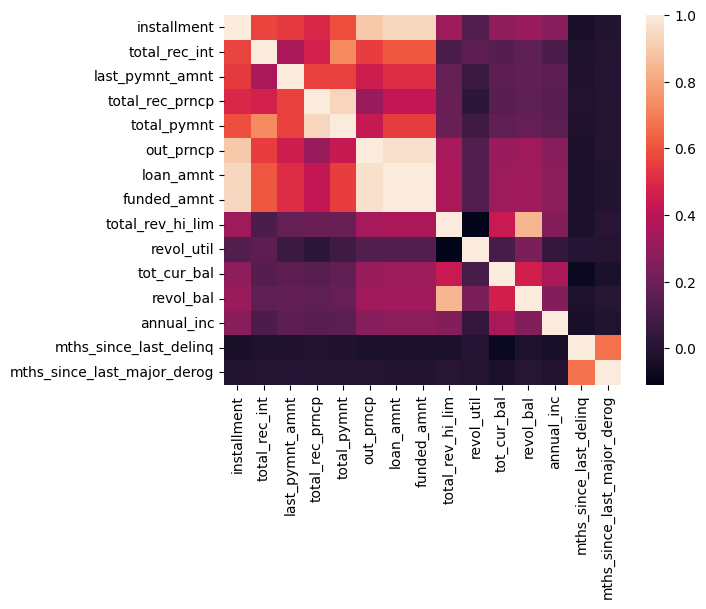

In [194]:
sns.heatmap(correl,annot=False)
plt.show()

Now we will some features with low correlation and see what happens.

In [195]:
low_cor_feat = ['installment','total_rec_int','revol_util','last_pymnt_amnt']
temp=df_new.drop(columns=['target','grade','index','int_rate'])
x= temp[['installment','total_rec_int','revol_util','last_pymnt_amnt']]
y=df_new['target']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,stratify=y,random_state=42)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
rfc=RandomForestClassifier(n_estimators=200,random_state=42)
rfc.fit(x_train_scaled,y_train)
feat_imp =pd.Series(rfc.feature_importances_,index=x.columns)
most_useful = feat_imp.sort_values(ascending=False)
most_useful

,0
installment,0.419763
last_pymnt_amnt,0.337681
total_rec_int,0.162448
revol_util,0.080108


In [196]:
pred=rfc.predict(x_test_scaled)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     14295
           1       0.97      0.78      0.86      1995

    accuracy                           0.97     16290
   macro avg       0.97      0.89      0.92     16290
weighted avg       0.97      0.97      0.97     16290



We can see that precision is high with the least correlated features, which makes sense since we only included original information in the model. This means that a lot of variables contain the same or similar information and do not genuinely contribute to the classification.

#5. Dimensionality Reduction with MNIST

In this part we will focus on dimensionality reduction techniques on the MNIST dataset.

In [165]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [166]:
from tensorflow.keras.datasets import mnist

In [167]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [168]:
x_train_v = x_train.reshape(-1,28*28)
x_test_v = x_test.reshape(-1,28*28)
x_train_v.shape , x_test_v.shape

((60000, 784), (10000, 784))

In [169]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_v)
x_test_scaled = scaler.transform(x_test_v)

In [170]:
pca = PCA(n_components=300)

In [171]:
x_train_reduced = pca.fit_transform(x_train_scaled)
x_test_reduced = pca.transform(x_test_scaled)
x_train_reduced.shape , x_test_reduced.shape

((60000, 300), (10000, 300))

We will use the fit_transform only on the train set. If we used it on the test set as well, then the scaling of the test set would be done based on its characteristics, which is not what the model expects / was trained on.

In addition, if we used the fit_transform before splitiing into train and test, then we risk leaking information of the test set into the training procedure, which severly compromises our implementation.

In [172]:
possible_k = [5,15,51, 101]

In [173]:
acuuracies_train = []
accuracies_test = []
for k in possible_k:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(x_train_reduced,y_train)

  y_pred_train = knn.predict(x_train_reduced)
  train_accuracy = accuracy_score(y_train, y_pred_train)*100
  acuuracies_train.append(train_accuracy)
  print(f'k = {k} Train: Acc={train_accuracy:.2f}')

  y_pred_test = knn.predict(x_test_reduced)
  test_accuracy = accuracy_score(y_test, y_pred_test)*100
  accuracies_test.append(test_accuracy)
  print(f'k = {k} Test: Acc={test_accuracy:.2f}')
  print('----------')

k = 5 Train: Acc=96.82
k = 5 Test: Acc=94.97
----------
k = 15 Train: Acc=95.16
k = 15 Test: Acc=94.36
----------
k = 51 Train: Acc=93.10
k = 51 Test: Acc=92.73
----------
k = 101 Train: Acc=91.67
k = 101 Test: Acc=91.58
----------


In [174]:
lda = LDA(n_components=2)
x_train_lda = lda.fit_transform(x_train_scaled, y_train)
x_test_lda  = lda.transform(x_test_scaled)

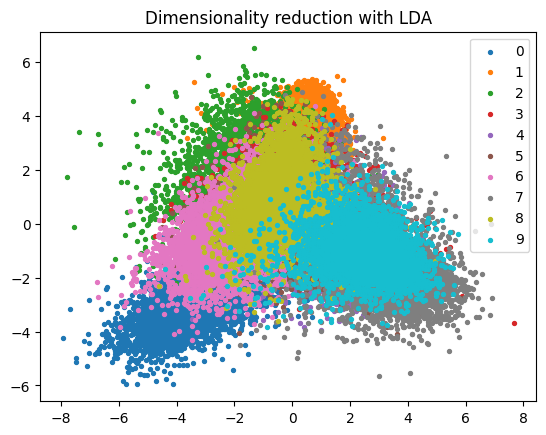

In [175]:
for i in range(10):
  xprint=[]
  yprint=[]
  for j in range(len(y_train)):
    if y_train[j]==i:
      xprint.append(x_train_lda[j,0])
      yprint.append(x_train_lda[j,1])

  plt.scatter(xprint,yprint,label=str(i),s=8)
plt.title('Dimensionality reduction with LDA')
plt.legend()
plt.show()

We can see that the observations seem dense and centered. Despite that, some digits are separated / grouped in specific areas.

In [176]:
import umap

In [177]:
umap_reducer = umap.UMAP(n_components=2)

In [178]:
x_train_umap = umap_reducer.fit_transform(x_train_scaled)

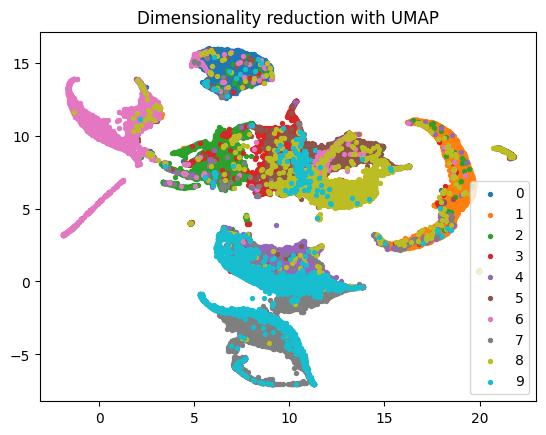

In [179]:
for i in range(10):
  xprint=[]
  yprint=[]
  for j in range(len(y_train)):
    if y_train[j]==i:
      xprint.append(x_train_umap[j,0])
      yprint.append(x_train_umap[j,1])

  plt.scatter(xprint,yprint,label=str(i),s=8)
plt.legend()
plt.title('Dimensionality reduction with UMAP')
plt.show()

We can see that this method does a better job in grouping data in different areas and thus, creating a figure that is easier to interpret. However, there are many observations that seem "misplaced", compared to the LDA.